# Classification

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from RAC.rac import RacClassifier
from sklearn.cluster import KMeans
import collections
from kneed import KneeLocator
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('../../dataset/trainU.csv', sep=',', index_col=0)

In [3]:
df.head()

,TPD52L2,PQBP1,UBC,MSN,TECPR2,HTRA1,TSC2,TFPI2,BRMS1,RNF122,...,TMEM120B,GMPS,STX17,MYO10,DCTN5,ACOT8,DDX41,NUP37,S100A13,DISEASE
DIABETE_80,0.317308,0.524752,0.423841,0.609589,0.038095,0.570313,0.194444,0.259825,0.611940,0.502262,...,0.299145,0.834951,0.678571,0.318898,0.222222,0.287770,0.574713,0.550459,0.481865,DIABETE
MCM_24,0.212228,0.397281,0.387946,0.434344,0.582763,0.377927,0.750613,0.156657,0.670648,0.565605,...,0.836315,0.480588,0.544868,0.512937,0.572418,0.295262,0.444807,0.199677,0.707201,MCM
DIABETE_117,1.000000,0.195577,1.000000,0.484255,0.000000,0.282397,0.432391,1.000000,0.430812,0.085137,...,0.867477,0.670118,0.050938,0.511076,0.000000,0.459641,0.381262,1.000000,0.050781,DIABETE
A1A_39,0.375781,0.000000,0.436904,0.469231,0.247460,0.050300,0.149881,0.233997,0.007119,0.805700,...,0.193024,0.911520,0.851867,0.230744,0.433154,0.191503,0.181347,0.386808,0.069342,A1A
GS_12,0.551092,0.914364,0.293751,0.438265,0.707744,0.818267,0.713636,0.824889,0.382334,0.674181,...,0.000000,0.465992,0.866507,0.867688,0.706209,0.169942,0.448738,0.688865,0.067062,GS


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, DIABETE_80 to A1A_111
Columns: 4421 entries, TPD52L2 to DISEASE
dtypes: float64(4420), object(1)
memory usage: 10.1+ MB


In [5]:
df['DISEASE'].value_counts()

DIABETE    132
A1A         96
NALD        28
GS          22
MCM         21
Name: DISEASE, dtype: int64

In [6]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

Train and validation by hand

In [7]:
train_x, val_x, train_y, val_y = train_test_split(df[data_cols], df['DISEASE'], test_size=.25, stratify=df['DISEASE'])

Train for CV

In [8]:
train_cv, target_cv = df.loc[:, df.columns != 'DISEASE'].copy(), df['DISEASE'].copy()

In [9]:
# Return compact form for GridSearchCV results
# It should receive clf.cv_results_ after GridSearchCV
def grid_search_report(results):
    results_df = pd.DataFrame(results)
    rank = ['rank_test_accuracy']
    columns = ['rank_test_accuracy', 
               'mean_test_accuracy', 'mean_train_accuracy', 'std_test_accuracy', 'std_train_accuracy',
               'mean_fit_time', 'params']
    results_df = results_df.sort_values(by=rank)
    results_df = results_df[columns]
    return results_df

## SVC

### Example test

In [11]:
clf = SVC()

In [12]:
clf.fit(train_x, train_y)

SVC()

In [13]:
clf.fit(train_x, train_y).score(train_x, train_y)

1.0

In [14]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       0.96      1.00      0.98        23
     DIABETE       1.00      0.77      0.87        43
          GS       0.67      1.00      0.80         4
         MCM       0.40      1.00      0.57         2
        NALD       0.43      1.00      0.60         3

    accuracy                           0.87        75
   macro avg       0.69      0.95      0.76        75
weighted avg       0.93      0.87      0.88        75



### Grid search

In [145]:
scoring = ['accuracy']
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [199]:
# 20 minuti con questi parametri e 3 fold
param_grid = [
    {'kernel': ['poly'],
     'gamma': ['scale'],
     'C': list(np.arange(1, 10, 0.2)),
     'degree': list(np.arange(1, 4, 1)),
     'coef0': list(np.arange(2, 3, 0.1)),
     'shrinking': [True],
     'class_weight': ['balanced']
    }
]

In [200]:
cv = StratifiedKFold(n_splits=3)

In [201]:
clf = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, scoring=scoring, refit=False, n_jobs=-1, return_train_score=True)
clf.fit(train_cv, target_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1.0, 1.1, 1.2000000000000002,
                                1.3000000000000003, 1.4000000000000004,
                                1.5000000000000004, 1.6000000000000005,
                                1.7000000000000006, 1.8000000000000007,
                                1.9000000000000008, 2.000000000000001,
                                2.100000000000001, 2.200000000000001,
                                2.30000000000000...
                                3.9000000000000026, ...],
                          'class_weight': ['balanced'],
                          'coef0': [1.5, 1.6, 1.7000000000000002,
                                    1.8000000000000003, 1.9000000000000004,
                                    2.0000000000000004, 2.1000000000000005,
                                    2.2000000000000006, 2.3000000000000007,
 

In [211]:
grid_search_report(clf.cv_results_)
#p = grid_search_report(clf.cv_results_)[0:500]['params']
#tmp = []
#for i in p:
#    tmp.append(i['coef0'])
#plt.hist(tmp)

,rank_test_accuracy,mean_test_accuracy,mean_train_accuracy,std_test_accuracy,std_train_accuracy,mean_fit_time,params
1003,1,0.933131,1.0,0.004428,0.0,0.427606,"{'C': 4.3000000000000025, 'class_weight': 'bal..."
2269,1,0.933131,1.0,0.004428,0.0,0.442469,"{'C': 8.500000000000007, 'class_weight': 'bala..."
1243,1,0.933131,1.0,0.004428,0.0,0.416685,"{'C': 5.100000000000003, 'class_weight': 'bala..."
493,1,0.933131,1.0,0.004428,0.0,0.420594,"{'C': 2.6000000000000014, 'class_weight': 'bal..."
2272,1,0.933131,1.0,0.004428,0.0,0.452644,"{'C': 8.500000000000007, 'class_weight': 'bala..."
...,...,...,...,...,...,...,...
1459,1,0.933131,1.0,0.004428,0.0,0.461087,"{'C': 5.800000000000004, 'class_weight': 'bala..."
19,1,0.933131,1.0,0.004428,0.0,0.510576,"{'C': 1.0, 'class_weight': 'balanced', 'coef0'..."
1486,1,0.933131,1.0,0.004428,0.0,0.421941,"{'C': 5.900000000000004, 'class_weight': 'bala..."
1948,1,0.933131,1.0,0.004428,0.0,0.516391,"{'C': 7.400000000000006, 'class_weight': 'bala..."


In [209]:
print('Test: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_test_accuracy']))
print('Train: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_train_accuracy']))

Test: 0.9331313131313133
Train: 1.0


In [210]:
best_params = grid_search_report(clf.cv_results_).iloc[0]['params']
best_params

{'C': 4.3000000000000025,
 'class_weight': 'balanced',
 'coef0': 1.9000000000000004,
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'poly',
 'shrinking': True}

In [216]:
#best_params = {'C': 4.3, 'class_weight': 'balanced', 'coef0': 1.9, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}

In [217]:
clf = SVC(**best_params)
clf.fit(train_x, train_y)

In [219]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        24
     DIABETE       0.97      1.00      0.99        33
          GS       1.00      1.00      1.00         6
         MCM       1.00      1.00      1.00         5
        NALD       1.00      0.86      0.92         7

    accuracy                           0.99        75
   macro avg       0.99      0.97      0.98        75
weighted avg       0.99      0.99      0.99        75



### Feature selection

This feature selection works in steps, at each step it tries to reduce the number of features recursively:
   1. Select most important features using a random forest classifier (model.get_support())
   2. Select most important features using recursive feature elimination (rfe.get_support())
    
Not necessarily the results are better after the step 2

#### Feature importance RandomForest

Optimal number of features : 1025


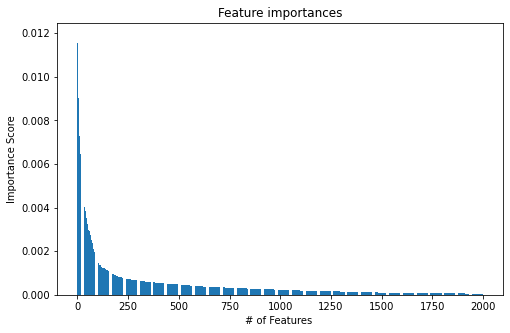

In [143]:
# Use RandomForestClassifier to select most important features

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(train_cv, target_cv)
model = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', model.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [144]:
# To select most important features
fs_train_cv_1 = train_cv.loc[:, model.get_support()]

In [153]:
cross_val_1 = cross_validate(SVC(**best_params), fs_train_cv_1, target_cv, cv=cv, scoring=scoring, return_train_score=True)

In [154]:
print('Test score: '+str(cross_val_1['test_accuracy'].mean()))
print('Train score: '+str(cross_val_1['train_accuracy'].mean()))

Test score: 0.9398305084745763
Train score: 1.0


#### Recursive Feature Elimination

Optimal number of features : 125


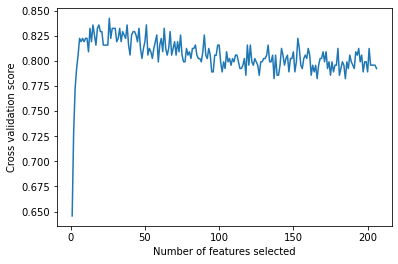

In [156]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=5, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(fs_train_cv_1, target_cv)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [157]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=rfecv.n_features_, step=5)
rfe = rfe.fit(fs_train_cv_1, target_cv)

In [158]:
fs_train_cv_2 = fs_train_cv_1.loc[:, rfe.get_support()]

In [159]:
cross_val_2 = cross_validate(SVC(**best_params), fs_train_cv_2, target_cv, cv=cv, scoring=scoring, return_train_score=True)

In [160]:
print('Test score: '+str(cross_val_2['test_accuracy'].mean()))
print('Train score: '+str(cross_val_2['train_accuracy'].mean()))

Test score: 0.9130508474576271
Train score: 1.0


#### Test best feature selection

In [224]:
clf = SVC(**best_params)
clf.fit(train_x.loc[:, model.get_support()], train_y)

SVC(C=4.3, class_weight='balanced', coef0=1.9, degree=2, kernel='poly')

In [226]:
print(classification_report(val_y, clf.predict(val_x.loc[:, model.get_support()])))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        24
     DIABETE       0.97      1.00      0.99        33
          GS       1.00      1.00      1.00         6
         MCM       1.00      1.00      1.00         5
        NALD       1.00      0.86      0.92         7

    accuracy                           0.99        75
   macro avg       0.99      0.97      0.98        75
weighted avg       0.99      0.99      0.99        75



## RAC

### Example test

In [10]:
clf = RacClassifier()

In [11]:
clf.fit(train_x, train_y)

RacClassifier()

In [12]:
clf.fit(train_x, train_y).score(train_x, train_y)

0.8794642857142857

In [13]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       0.68      0.96      0.79        24
     DIABETE       1.00      0.45      0.62        33
          GS       0.67      1.00      0.80         6
         MCM       0.45      1.00      0.62         5
        NALD       1.00      0.86      0.92         7

    accuracy                           0.73        75
   macro avg       0.76      0.85      0.75        75
weighted avg       0.83      0.73      0.72        75



### Grid search

In [14]:
scoring = ['accuracy']
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [15]:
param_grid = [
    {'weighted': [True, False]
    }
]

In [16]:
cv = StratifiedKFold(n_splits=3)

In [17]:
clf = GridSearchCV(estimator=RacClassifier(), param_grid=param_grid, cv=cv, scoring=scoring, refit=False, n_jobs=-1, return_train_score=True)
clf.fit(train_cv, target_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RacClassifier(), n_jobs=-1,
             param_grid=[{'weighted': [True, False]}], refit=False,
             return_train_score=True, scoring=['accuracy'])

In [18]:
grid_search_report(clf.cv_results_)
#p = grid_search_report(clf.cv_results_)[0:500]['params']
#tmp = []
#for i in p:
#    tmp.append(i['coef0'])
#plt.hist(tmp)

,rank_test_accuracy,mean_test_accuracy,mean_train_accuracy,std_test_accuracy,std_train_accuracy,mean_fit_time,params
1,1,0.772559,0.889615,0.012725,0.008412,0.248875,{'weighted': False}
0,2,0.769192,0.899665,0.022003,0.004110,0.412053,{'weighted': True}


In [19]:
print('Test: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_test_accuracy']))
print('Train: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_train_accuracy']))

Test: 0.7725589225589226
Train: 0.8896147403685092


In [20]:
best_params = grid_search_report(clf.cv_results_).iloc[0]['params']
best_params

{'weighted': False}

In [21]:
clf = RacClassifier(**best_params)
clf.fit(train_x, train_y)

RacClassifier()

In [22]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       0.68      0.96      0.79        24
     DIABETE       1.00      0.45      0.62        33
          GS       0.67      1.00      0.80         6
         MCM       0.45      1.00      0.62         5
        NALD       1.00      0.86      0.92         7

    accuracy                           0.73        75
   macro avg       0.76      0.85      0.75        75
weighted avg       0.83      0.73      0.72        75



### Feature selection

#### Feature importance RandomForest

Optimal number of features : 985


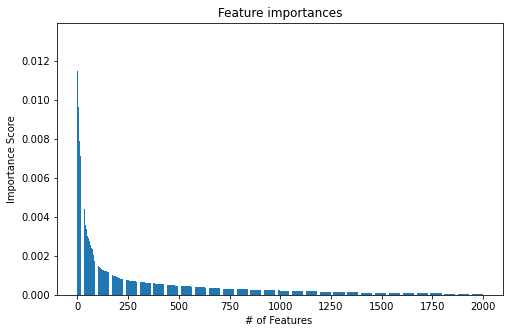

In [23]:
# Use RandomForestClassifier to select most important features

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(train_cv, target_cv)
model = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', model.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [24]:
# To select most important features
fs_train_cv_1 = train_cv.loc[:, model.get_support()]

In [25]:
cross_val_1 = cross_validate(RacClassifier(**best_params), fs_train_cv_1, target_cv, cv=cv, scoring=scoring, return_train_score=True)

In [26]:
print('Test score: '+str(cross_val_1['test_accuracy'].mean()))
print('Train score: '+str(cross_val_1['train_accuracy'].mean()))

Test score: 0.8025925925925925
Train score: 0.903031825795645


#### Recursive Feature Elimination

Optimal number of features : 120


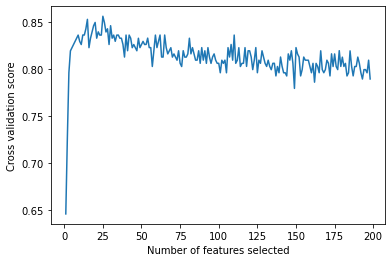

In [27]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=5, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(fs_train_cv_1, target_cv)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [28]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=rfecv.n_features_, step=5)
rfe = rfe.fit(fs_train_cv_1, target_cv)

In [29]:
fs_train_cv_2 = fs_train_cv_1.loc[:, rfe.get_support()]

In [31]:
cross_val_2 = cross_validate(RacClassifier(**best_params), fs_train_cv_2, target_cv, cv=cv, scoring=scoring, return_train_score=True)

In [32]:
print('Test score: '+str(cross_val_2['test_accuracy'].mean()))
print('Train score: '+str(cross_val_2['train_accuracy'].mean()))

Test score: 0.8261952861952863
Train score: 0.8678894472361809


#### Test best feature selection

In [33]:
clf = RacClassifier(**best_params)
clf.fit(train_x.loc[:, model.get_support()].loc[:, rfe.get_support()], train_y)

RacClassifier()

In [34]:
print(classification_report(val_y, clf.predict(val_x.loc[:, model.get_support()].loc[:, rfe.get_support()])))

              precision    recall  f1-score   support

         A1A       0.80      1.00      0.89        24
     DIABETE       1.00      0.70      0.82        33
          GS       0.75      1.00      0.86         6
         MCM       0.71      1.00      0.83         5
        NALD       0.86      0.86      0.86         7

    accuracy                           0.85        75
   macro avg       0.82      0.91      0.85        75
weighted avg       0.88      0.85      0.85        75



## KNN

### Example test

In [10]:
clf = KNeighborsClassifier()

In [11]:
clf.fit(train_x, train_y)

KNeighborsClassifier()

In [12]:
clf.fit(train_x, train_y).score(train_x, train_y)

0.8526785714285714

In [13]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       0.65      1.00      0.79        24
     DIABETE       0.76      0.67      0.71        33
          GS       1.00      0.83      0.91         6
         MCM       1.00      0.80      0.89         5
        NALD       0.00      0.00      0.00         7

    accuracy                           0.73        75
   macro avg       0.68      0.66      0.66        75
weighted avg       0.69      0.73      0.70        75



/opt/anaconda3/envs/chl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/chl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/chl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Grid search

In [14]:
scoring = ['accuracy']
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [15]:
param_grid = [
    {'n_neighbors': list(np.arange(1, 10, 1)),
     'weights': ['distance'],
     'algorithm': ['brute', 'ball_tree', 'kd_tree'],
     'p': [1, 2]
    }
]

In [16]:
cv = StratifiedKFold(n_splits=3)

In [17]:
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=cv, scoring=scoring, refit=False, n_jobs=-1, return_train_score=True)
clf.fit(train_cv, target_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['brute', 'ball_tree', 'kd_tree'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'p': [1, 2], 'weights': ['distance']}],
             refit=False, return_train_score=True, scoring=['accuracy'])

In [18]:
grid_search_report(clf.cv_results_)
#p = grid_search_report(clf.cv_results_)[0:10]['params']
#tmp = []
#for i in p:
    #tmp.append(i['leaf_size'])
#plt.hist(tmp)

,rank_test_accuracy,mean_test_accuracy,mean_train_accuracy,std_test_accuracy,std_train_accuracy,mean_fit_time,params
0,1,0.903030,1.0,0.016883,0.0,0.241213,"{'algorithm': 'brute', 'n_neighbors': 1, 'p': ..."
2,1,0.903030,1.0,0.016883,0.0,0.127446,"{'algorithm': 'brute', 'n_neighbors': 2, 'p': ..."
20,1,0.903030,1.0,0.016883,0.0,0.260758,"{'algorithm': 'ball_tree', 'n_neighbors': 2, '..."
18,1,0.903030,1.0,0.016883,0.0,0.253932,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '..."
36,1,0.903030,1.0,0.016883,0.0,0.141464,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'p'..."
38,1,0.903030,1.0,0.016883,0.0,0.144120,"{'algorithm': 'kd_tree', 'n_neighbors': 2, 'p'..."
1,7,0.893064,1.0,0.024658,0.0,0.189294,"{'algorithm': 'brute', 'n_neighbors': 1, 'p': ..."
3,7,0.893064,1.0,0.024658,0.0,0.122514,"{'algorithm': 'brute', 'n_neighbors': 2, 'p': ..."
21,7,0.893064,1.0,0.024658,0.0,0.224012,"{'algorithm': 'ball_tree', 'n_neighbors': 2, '..."
19,7,0.893064,1.0,0.024658,0.0,0.200275,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '..."


In [19]:
print('Test: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_test_accuracy']))
print('Train: '+ str(grid_search_report(clf.cv_results_).iloc[0]['mean_train_accuracy']))

Test: 0.903030303030303
Train: 1.0


In [20]:
best_params = grid_search_report(clf.cv_results_).iloc[0]['params']
best_params

{'algorithm': 'brute', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

In [21]:
#best_params = {'algorithm': 'brute', 'weights': 'distance', 'n_neighbors': 1, 'p': 1}

In [22]:
clf = KNeighborsClassifier(**best_params)
clf.fit(train_x, train_y)

KNeighborsClassifier(algorithm='brute', n_neighbors=1, p=1, weights='distance')

In [23]:
print(classification_report(val_y, clf.predict(val_x)))

              precision    recall  f1-score   support

         A1A       0.89      1.00      0.94        24
     DIABETE       0.88      0.91      0.90        33
          GS       1.00      1.00      1.00         6
         MCM       1.00      1.00      1.00         5
        NALD       1.00      0.43      0.60         7

    accuracy                           0.91        75
   macro avg       0.95      0.87      0.89        75
weighted avg       0.91      0.91      0.90        75



### Feature selection

This feature selection works in steps, at each step it tries to reduce the number of features recursively:
   1. Select most important features using a random forest classifier (model.get_support())
   2. Select most important features using recursive feature elimination (rfe.get_support())
    
Not necessarily the results are better after the step 2

#### Feature importance RandomForest

Optimal number of features : 989


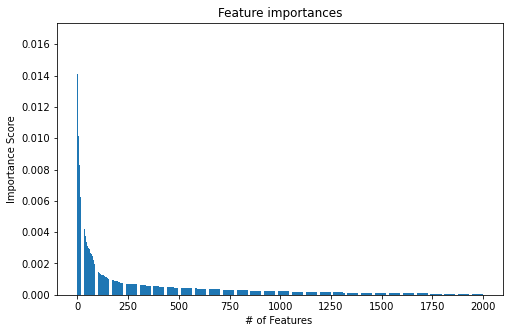

In [24]:
# Use RandomForestClassifier to select most important features

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(train_cv, target_cv)
model = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', model.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [27]:
rf_cols = list(compress(data_cols, model.get_support()))

In [28]:
# To select most important features
fs_train_cv_1 = train_cv[rf_cols]

In [29]:
cross_val_1 = cross_validate(KNeighborsClassifier(**best_params), fs_train_cv_1, target_cv, cv=cv, scoring=scoring, return_train_score=True)

In [30]:
print('Test score: '+str(cross_val_1['test_accuracy'].mean()))
print('Train score: '+str(cross_val_1['train_accuracy'].mean()))

Test score: 0.9398316498316498
Train score: 1.0


#### Recursive Feature Elimination

In [31]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=5, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(fs_train_cv_1, target_cv)
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 144


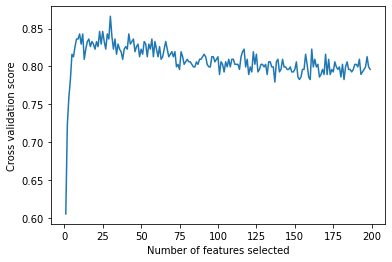

In [32]:
# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [33]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=rfecv.n_features_, step=5)
rfe = rfe.fit(fs_train_cv_1, target_cv)

In [34]:
rfe_cols = list(compress(rf_cols, rfe.get_support()))

In [35]:
fs_train_cv_2 = fs_train_cv_1[rfe_cols]

In [36]:
cross_val_2 = cross_validate(KNeighborsClassifier(**best_params), fs_train_cv_2, target_cv, cv=cv, scoring=scoring, return_train_score=True)


In [37]:
print('Test score: '+str(cross_val_2['test_accuracy'].mean()))
print('Train score: '+str(cross_val_2['train_accuracy'].mean()))

Test score: 0.9498653198653199
Train score: 1.0


#### Test best feature selection

In [38]:
clf = KNeighborsClassifier(**best_params)
clf.fit(train_x[rfe_cols], train_y)

KNeighborsClassifier(algorithm='brute', n_neighbors=1, p=1, weights='distance')

In [39]:
print(classification_report(val_y, clf.predict(val_x[rfe_cols])))

              precision    recall  f1-score   support

         A1A       0.96      1.00      0.98        24
     DIABETE       0.94      0.97      0.96        33
          GS       0.86      1.00      0.92         6
         MCM       1.00      1.00      1.00         5
        NALD       1.00      0.57      0.73         7

    accuracy                           0.95        75
   macro avg       0.95      0.91      0.92        75
weighted avg       0.95      0.95      0.94        75



## KMeans

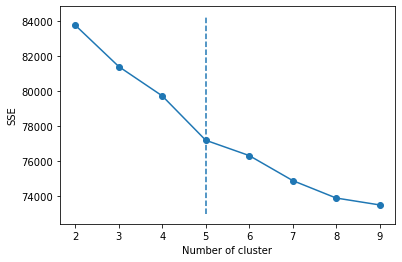

In [12]:
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(train_cv)
    sse.append((k, kmeans.inertia_))

plt.figure()
kn = KneeLocator(*zip(*sse), curve='convex', direction='decreasing')
plt.plot(*zip(*sse), '-o')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [13]:
kmeans = KMeans(5).fit(train_cv)

In [14]:
kmeans_labels = kmeans.labels_

In [15]:
collections.Counter(kmeans_labels)

Counter({3: 30, 2: 159, 1: 84, 0: 7, 4: 19})

In [16]:
target_cv.value_counts()

DIABETE    132
A1A         96
NALD        28
GS          22
MCM         21
Name: DISEASE, dtype: int64

In [17]:
translation_dict = {'3': 'DIABETE',
             '1': 'A1A',
             '0': 'NALD',
             '4': 'GS',
             '2': 'MCM'
}

kmeans_labels = [translation_dict[str(lab)] for lab in list(kmeans_labels)]

In [18]:
print(classification_report(target_cv, kmeans_labels))

              precision    recall  f1-score   support

         A1A       0.99      0.86      0.92        96
     DIABETE       0.97      0.22      0.36       132
          GS       0.00      0.00      0.00        22
         MCM       0.13      1.00      0.23        21
        NALD       0.00      0.00      0.00        28

    accuracy                           0.44       299
   macro avg       0.42      0.42      0.30       299
weighted avg       0.75      0.44      0.47       299

